In [1]:
from transformers import DistilBertTokenizer, AutoModel
from datasets import load_dataset

import torch
import torch.nn as nn
import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers_tutorial.networks.sequence_classifier import SequenceClassification
from transformers_tutorial.networks.trainer import Trainer

/home/user/mambaforge/envs/env/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
model_name = "distilbert-base-uncased"
device = "cuda"

In [3]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
model = AutoModel.from_pretrained(model_name).to(device)

# Testing a sample string

In [5]:
text = "Tokenizing text is a core task in NLP."

encoded_text = tokenizer(text)

In [6]:
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1999, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
# tokenizer.convert_ids_to_tokens([5323, 103, 2003]), 
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_text.input_ids))

'[CLS] tokenizing text is a core task in nlp . [SEP]'

In [8]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

In [9]:
len(tokenizer("start " * 512).input_ids) # Why it does not throw error?

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


514

# Load dataset

In [10]:
emotions = load_dataset("emotion")

In [11]:
tokenize_batch = lambda x: tokenizer(x['text'], padding=True, truncation=True, return_tensors='pt')

In [12]:
tokenize_batch(emotions["train"][:3])

{'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102],
        [  101, 10047,  9775,  1037,  3371,  2000,  2695,  1045,  2514, 20505,
          3308,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [13]:
emotions_encoded = emotions.map(tokenize_batch, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
len(emotions_encoded['train']['input_ids'][0]), len(emotions_encoded['test']['input_ids'][0]), 

(87, 66)

# Running the model

In [15]:
test_text = "this is a test."

In [16]:
inputs = {k: v.to(device) for k, v in tokenizer(test_text, return_tensors="pt").items()}
inputs['input_ids'].shape

torch.Size([1, 7])

In [17]:
with torch.no_grad():
    outputs = model(**inputs)

In [18]:
outputs.last_hidden_state.shape

torch.Size([1, 7, 768])

In [19]:
outputs.last_hidden_state[:,0].shape

torch.Size([1, 768])

## Extract last hidden layer

In [20]:
emotions_encoded.set_format("torch", columns=["label", "attention_mask", "input_ids"])

In [21]:
def extract_last_hidden_layer(batch):
    with torch.no_grad():
        inputs_ = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
        lh = model(**inputs_).last_hidden_state[:,0]
        return {"last_hidden_state": lh.to(device)}

In [22]:
# Fetch from cache is enabled; so the computation won't be run again.
emotions_lh = emotions_encoded.map(extract_last_hidden_layer, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
sampled_data = emotions_lh['train'].shuffle().select([i for i in range(1000)])
emotions_lh['train_sampled'] = sampled_data

In [24]:
emotions_lh

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state'],
        num_rows: 2000
    })
    train_sampled: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state'],
        num_rows: 1000
    })
})

In [25]:
(X_train, y_train), (X_val, y_val) = [
    [emotions_lh[data_type][col].numpy() for col in ("last_hidden_state", "label")] 
    for data_type in  ("train", "validation")
]

In [26]:
pipe = Pipeline(
    [
        ("minmax", MinMaxScaler()),
        ("umap", umap.UMAP(n_components=2, metric='cosine'))
    ]
)

In [27]:
pipe.fit(X_train)

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('umap',
                 UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

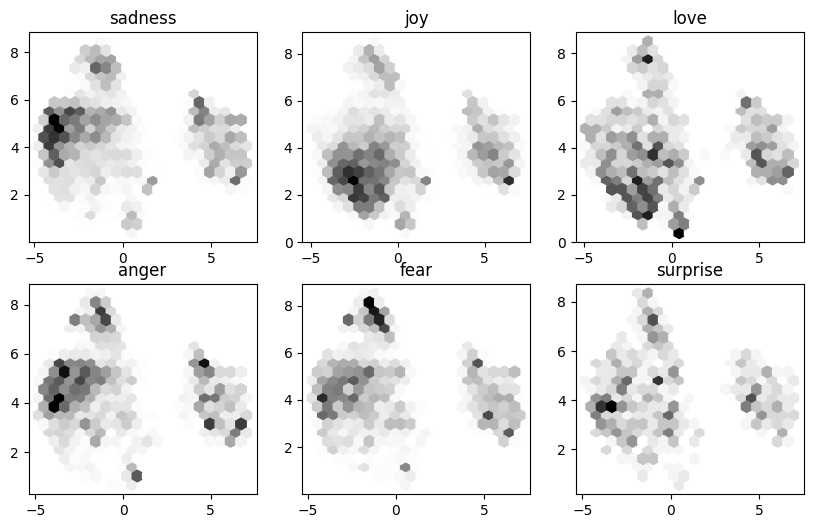

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()
X_emb = pipe.transform(X_train)
df_emb = pd.DataFrame(X_emb, columns=[f"X{i}" for i in range(X_emb.shape[1])])
df_emb['label'] = y_train
labels = emotions_lh['train'].features['label'].names

for i, label in enumerate(labels):
    df_sub_ = df_emb.query(f"label == {i}")
    ax[i].hexbin(df_sub_['X0'], df_sub_['X1'], gridsize=20, cmap="Grays")
    ax[i].set_title(label)

## Simple model

In [29]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)

/home/user/mambaforge/envs/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

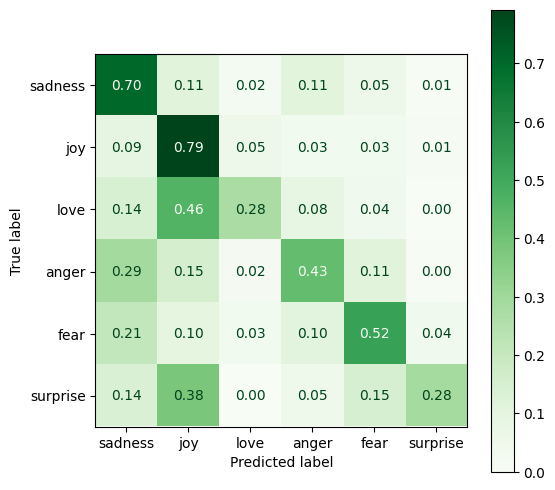

In [30]:
def display_cm(y_pred, y_true, label_names):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
    disp.plot(cmap="Greens", values_format=".2f", ax=ax)
    return disp, fig, ax
    
y_pred = lr.predict(X_val)
disp_, _, _ = display_cm(y_pred, y_val, labels)

# Fine-tuning

In [31]:
def get_grads(model_):
    output = {}
    for name, param in seq_clf.named_parameters():
        if param.requires_grad:
            output[name] = param.grad
    return output

In [32]:
pd.Series(emotions_lh['train_sampled']['label'].numpy()).value_counts()

1    354
0    262
3    153
4    116
2     78
5     37
Name: count, dtype: int64

In [36]:
seq_clf = SequenceClassification(hf_language_model=model_name, n_classification_layer=6, device=device)
optimizer = torch.optim.AdamW(
    params={p for p in seq_clf.parameters() if p.requires_grad}, 
    lr=1e-5, weight_decay=0.01
)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(optimizer=optimizer, loss=loss_fn, model=seq_clf)

In [37]:
emotions_lh['train_sampled'].features.keys()

dict_keys(['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state'])

In [38]:
BATCH_SIZE = 64
N_EPOCHS = 2

_ = trainer.train(train_data=emotions_lh['train'], 
                  validation_data=emotions_lh['validation'], 
                  n_epochs=N_EPOCHS,
                  batch_size=BATCH_SIZE)

Epoch 0: 100%|█████████████████| 250/250 [00:23<00:00, 10.73batch/s]


2024-12-07 21:01:38,704 : INFO : transformers_tutorial.networks.trainer : validation loss: 0.29052242636680603


Epoch 1: 100%|█████████████████| 250/250 [00:23<00:00, 10.66batch/s]


2024-12-07 21:02:02,933 : INFO : transformers_tutorial.networks.trainer : validation loss: 0.170474573969841


In [38]:
def get_predictions(input_model):
    def wrapper(batch):        
        with torch.no_grad():
            inputs_ = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            y_pred_ = input_model(inputs_).argmax(axis=1)
    
        return {"clf_prediction": y_pred_}
    return wrapper

In [39]:
seq_clf_pred = emotions_encoded['validation'].map(get_predictions(seq_clf), batched=True, batch_size=100)['clf_prediction']

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

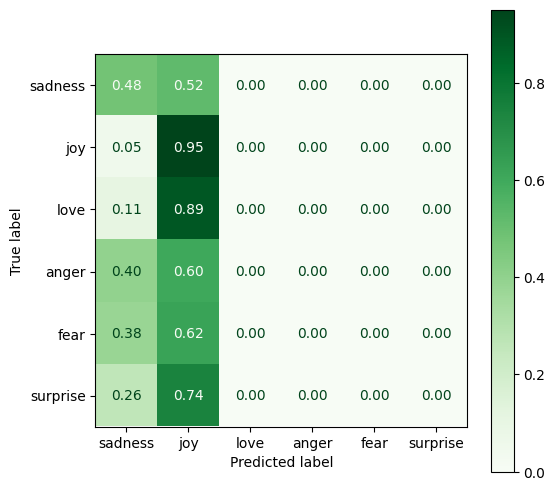

In [40]:
disp_, _, _ = display_cm(seq_clf_pred, emotions_encoded['validation']['label'], labels)

# Using Huggingface

In [123]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (
    AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
seq_clf

SequenceClassification(
  (lm): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [127]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [115]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [173]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_lh["train_sampled"]) // batch_size
output_dir = f"{model_name}-finetuned-emotion"
training_args = TrainingArguments( 
    output_dir=output_dir,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=10,
    push_to_hub=False, 
    log_level="error")     

In [174]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_lh["train_sampled"],
                  eval_dataset=emotions_lh["validation"],
                  tokenizer=tokenizer)

/tmp/ipykernel_133421/3738100366.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [175]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.613400,0.517378,0.830000,0.811724
2,0.398800,0.417298,0.869000,0.863207


TrainOutput(global_step=188, training_loss=0.5866778771928016, metrics={'train_runtime': 933.9199, 'train_samples_per_second': 12.849, 'train_steps_per_second': 0.201, 'total_flos': 270128573136000.0, 'train_loss': 0.5866778771928016, 'epoch': 2.0})

In [176]:
preds_output = trainer.predict(emotions_encoded["validation"])

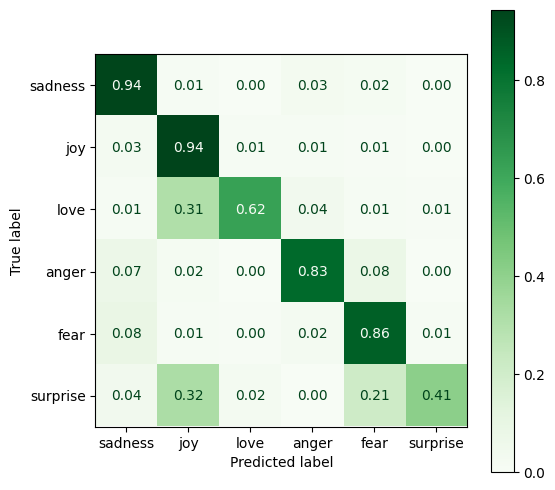

In [177]:
disp_, _, _ = display_cm(preds_output.predictions.argmax(axis=1), emotions_encoded['validation']['label'], labels)